ToDo 

[] reduce size of finetuning dataset 

[] see how performance changes as a function of the % of the finetuning dataset used

[x] create an end2end baseline 

[] change to 1 layer 

[x] update early stopping

[] investigate SGD

[] other stuff on slack 

[] randomsearch with wandb

In [177]:
import sys
sys.path.append('..')

from utils import *
from data_utils import *
from metrics import *
from plots import *

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

## Testing dataset generation 

In [178]:
def eval(model, device, dataset_loader, debug, classification_report_flag = False):
    model.eval()
    test_loss, correct = 0., 0.
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for data, target in dataset_loader:
            data, target = data.reshape([data.shape[0], -1]).to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(
                output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(
                dim=1,
                keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            
            all_preds.extend(pred.cpu().numpy())
            all_labels.extend(target.cpu().numpy())

    num_data = len(dataset_loader.dataset)
    test_loss /= num_data
    acc = correct / num_data
    if debug:
        print('\nTrain set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.
              format(test_loss, correct, num_data, 100. * acc))

    if classification_report_flag:
        print(classification_report(all_labels, all_preds, target_names=[f'Class {i}' for i in range(len(set(all_labels)))]))

    return acc


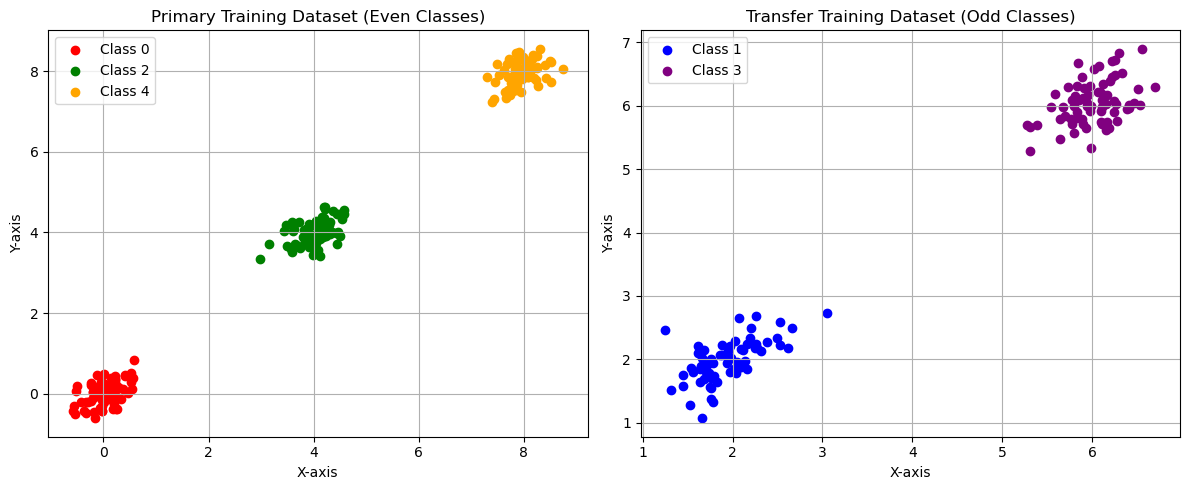

In [179]:
import numpy as np
import matplotlib.pyplot as plt

def generate_data(n_classes, n_points, base_covariance, shift, start_mean=0.0):
    """
    Generate synthetic data.
    
    Parameters:
        n_classes (int): The number of classes.
        n_points (int): The number of points per class.
        base_covariance (list of list of float): The base covariance matrix for generating points.
        shift (float): The shift in the mean for each subsequent class.
        
    Returns:
        X (np.ndarray): The feature array.
        y (np.ndarray): The label array.
    """
    
    X_list = []
    y_list = []
    
    for i in range(n_classes):
        # Mean for class i (shifted along the line y=x)
        mean = [start_mean + i * shift, start_mean + i * shift]
        
        # Generate points for class i
        x, y = np.random.multivariate_normal(mean, base_covariance, n_points).T
        
        # Labels for the points
        labels = np.full(n_points, i, dtype=int)
        
        X_list.append(np.column_stack((x, y)))
        y_list.append(labels)
        
    # Combine the points and labels
    X = np.vstack(X_list)
    y = np.concatenate(y_list)
    
    # Shuffle the dataset
    shuffle_indices = np.random.permutation(n_classes * n_points)
    X = X[shuffle_indices]
    y = y[shuffle_indices]
    
    return X, y

# Seed for reproducibility
np.random.seed(42)

# Number of classes
n_classes = 5

# Number of points per class
n_points = 100

# Base covariance matrix for generating points
base_covariance = [[0.1, 0.05], [0.05, 0.1]]
#base_covariance = [[0.2, -0.19], [-0.19, 0.2]]

# Shift in mean for each subsequent class
shift = 2.0

# Generate the data
# Generate the data
X, y = generate_data(n_classes, n_points, base_covariance, shift)

# Split the data into primary (even classes) and transfer (odd classes) datasets
X_primary = X[np.isin(y, [0, 2, 4])]
y_primary = y[np.isin(y, [0, 2, 4])]

X_transfer = X[np.isin(y, [1, 3])]
y_transfer = y[np.isin(y, [1, 3])]

# Splitting ratios
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

# Primary dataset: Split into train, validation, and test sets
X_primary_train, X_primary_temp, y_primary_train, y_primary_temp = train_test_split(X_primary, y_primary, test_size=(1-train_ratio))
X_primary_val, X_primary_test, y_primary_val, y_primary_test = train_test_split(X_primary_temp, y_primary_temp, test_size=test_ratio/(test_ratio+val_ratio))

# Transfer dataset: Split into train, validation, and test sets
X_transfer_train, X_transfer_temp, y_transfer_train, y_transfer_temp = train_test_split(X_transfer, y_transfer, test_size=(1-train_ratio))
X_transfer_val, X_transfer_test, y_transfer_val, y_transfer_test = train_test_split(X_transfer_temp, y_transfer_temp, test_size=test_ratio/(test_ratio+val_ratio))

# Plotting
# For brevity, I'm only plotting the training datasets for primary and transfer.
plt.figure(figsize=(12, 5))

# Primary training dataset
plt.subplot(1, 2, 1)
colors = ['red', 'blue', 'green', 'purple', 'orange']
for i in [0, 2, 4]:
    plt.scatter(X_primary_train[y_primary_train==i][:, 0], X_primary_train[y_primary_train==i][:, 1], color=colors[i % len(colors)], label=f'Class {i}')
plt.legend()
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Primary Training Dataset (Even Classes)')
plt.grid(True)

# Transfer training dataset
plt.subplot(1, 2, 2)
for i in [1, 3]:
    plt.scatter(X_transfer_train[y_transfer_train==i][:, 0], X_transfer_train[y_transfer_train==i][:, 1], color=colors[i % len(colors)], label=f'Class {i}')
plt.legend()
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Transfer Training Dataset (Odd Classes)')
plt.grid(True)

plt.tight_layout()
plt.show()



# ADAM IS THE KEY 

In [180]:
# like previous function, but run for given number of epochs determined by params['num_train']
def compute_training_acc_epochs(model, dataset, params, debug=False, save_checkpoints=False):
    device = torch.device(params['device'])
    optimizer = optim.Adam(model.parameters(), lr=params['lr'])   
    # if debug: print(model, optimizer)

    if params['early_stop_patience']:
        no_improve_epochs = 0
        max_val_acc = 0.

    train_acc = 0.0
    model.train()
    checkpoints = []

    # Loop over epochs
    for epoch in range(params['num_train']):
        for batch_idx, (data, target) in enumerate(dataset.train_loader):
            data, target = data.reshape([data.shape[0], -1]).to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = F.nll_loss(output, target)
            loss.backward()
            optimizer.step()

            if debug and batch_idx % 20 == 0:
                #print('Epoch: {} Train step: {} \tLoss: {:.6f}'.format(epoch, batch_idx, loss.item()))
                pass

        # Evaluate after each epoch
        if debug:
            train_acc = eval(model, device, dataset.train_loader, debug=False)
            print('Epoch: {} \tTraining Accuracy: {:.2f}%'.format(epoch, train_acc*100))
            # if debug and (epoch+1) % 1 == 0:
            val_acc = eval(model, device, dataset.val_loader, debug=False)
            print('Validation Accuracy: {:.2f}%'.format(val_acc*100))

            if params['early_stop_patience']:
                if val_acc > max_val_acc:
                    max_val_acc = val_acc
                    no_improve_epochs = 0
                else:
                    no_improve_epochs += 1
                    print("val_acc: {}, max_val_acc: {}, no_improve_epochs: {}".format(val_acc, max_val_acc, no_improve_epochs))
                    if no_improve_epochs >= params['early_stop_patience']:
                        print("Early stopping invoked.")
                        break
        
        if save_checkpoints:
            # Save checkpoint after each epoch
            checkpoint = {
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_acc': train_acc,
                'val_acc': val_acc
            }
            torch.save(checkpoint, 'checkpoint_epoch_{}.pth'.format(epoch))
            checkpoints.append(checkpoint)

    # Final evaluation after all epochs are completed
    train_acc = eval(model, device, dataset.train_loader, debug=False)
    test_acc = eval(model, device, dataset.test_loader, debug=False)
    if save_checkpoints:
        return train_acc, test_acc, model, checkpoints
    else:
        return train_acc, test_acc, model, []


In [181]:
def compute_training_acc_epochs(model, dataset, params, debug=False, save_checkpoints=False):
    device = torch.device(params['device'])
    optimizer = optim.Adam(model.parameters(), lr=params['lr'])   

    best_model_state = None  # To save the best model weights/state
    if params['early_stop_patience']:
        no_improve_epochs = 0
        max_val_acc = 0.

    train_acc = 0.0
    model.train()
    checkpoints = []

    # Loop over epochs
    for epoch in range(params['num_train']):
        for batch_idx, (data, target) in enumerate(dataset.train_loader):
            data, target = data.reshape([data.shape[0], -1]).to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = F.nll_loss(output, target)
            loss.backward()
            optimizer.step()

        # Evaluate after each epoch
        if debug:
            train_acc = eval(model, device, dataset.train_loader, debug=False)
            val_acc = eval(model, device, dataset.val_loader, debug=False)
            print('Epoch: {} \tTraining Accuracy: {:.2f}%'.format(epoch, train_acc*100))
            print('Validation Accuracy: {:.2f}%'.format(val_acc*100))

            if params['early_stop_patience']:
                if val_acc > max_val_acc:
                    max_val_acc = val_acc
                    best_model_state = model.state_dict().copy() # This line saves the best model state.
                    no_improve_epochs = 0
                    best_model_state = model.state_dict()  # Save the best model state
                else:
                    no_improve_epochs += 1
                    print("val_acc: {}, max_val_acc: {}, no_improve_epochs: {}".format(val_acc, max_val_acc, no_improve_epochs))
                    if no_improve_epochs >= params['early_stop_patience']:
                        print("Early stopping invoked.")
                        model.load_state_dict(best_model_state)  # Load the best model weights
                        break
        
        if save_checkpoints:
            checkpoint = {
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_acc': train_acc,
                'val_acc': val_acc
            }
            torch.save(checkpoint, 'checkpoint_epoch_{}.pth'.format(epoch))
            checkpoints.append(checkpoint)

    # At the end of training, load the best weights if early stopping wasn't invoked 
    # (in case the final epochs did not improve performance)
    if not params['early_stop_patience'] or no_improve_epochs < params['early_stop_patience']:
        model.load_state_dict(best_model_state)

    train_acc = eval(model, device, dataset.train_loader, debug=False)
    test_acc = eval(model, device, dataset.test_loader, debug=False)
    if save_checkpoints:
        return train_acc, test_acc, model, checkpoints
    else:
        return train_acc, test_acc, model, []


## Pretraining

In [182]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [183]:
device = 'cpu'

depth = 2

params = dict(device=device,
                width=5, lr=0.01, num_train=100,
                sb=0.05, depth= depth, sw=1.7346938775510203, early_stop_patience = 10, activation_function='tanh')

import torch
from torch.utils.data import TensorDataset, DataLoader

# Convert primary training data to PyTorch tensors
X_primary_train_tensor = torch.FloatTensor(X_primary_train)
y_primary_train_tensor = torch.LongTensor(y_primary_train)

# Convert primary validation data to PyTorch tensors
X_primary_val_tensor = torch.FloatTensor(X_primary_val)
y_primary_val_tensor = torch.LongTensor(y_primary_val)

# Convert primary test data to PyTorch tensors
X_primary_test_tensor = torch.FloatTensor(X_primary_test)
y_primary_test_tensor = torch.LongTensor(y_primary_test)

# Create DataLoaders for primary datasets
train_dataset = TensorDataset(X_primary_train_tensor, y_primary_train_tensor)
val_dataset = TensorDataset(X_primary_val_tensor, y_primary_val_tensor)
test_dataset = TensorDataset(X_primary_test_tensor, y_primary_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Create DNN model
input_dim = 2  # 2D data points
output_dim = n_classes  # Number of classes
model = generate_fc_dnn(input_dim, output_dim, params, gaussian_init=False, activation_function = nn.ReLU)

# Create a 'Namespace' to supply to the training function (to comply with your function's requirements)
from types import SimpleNamespace
dataset_namespace = SimpleNamespace(train_loader=train_loader, val_loader=val_loader, test_loader=test_loader)

# Train and evaluate
train_acc, test_acc, model, _ = compute_training_acc_epochs(model, dataset_namespace, params, debug=True)

print(f"Final Training Accuracy: {train_acc:.4f}")
print(f"Final Test Accuracy: {test_acc:.4f}")


Epoch: 0 	Training Accuracy: 67.46%
Validation Accuracy: 64.44%
Epoch: 1 	Training Accuracy: 65.55%
Validation Accuracy: 64.44%
val_acc: 0.6444444444444445, max_val_acc: 0.6444444444444445, no_improve_epochs: 1
Epoch: 2 	Training Accuracy: 64.59%
Validation Accuracy: 64.44%
val_acc: 0.6444444444444445, max_val_acc: 0.6444444444444445, no_improve_epochs: 2
Epoch: 3 	Training Accuracy: 66.03%
Validation Accuracy: 64.44%
val_acc: 0.6444444444444445, max_val_acc: 0.6444444444444445, no_improve_epochs: 3
Epoch: 4 	Training Accuracy: 66.51%
Validation Accuracy: 64.44%
val_acc: 0.6444444444444445, max_val_acc: 0.6444444444444445, no_improve_epochs: 4
Epoch: 5 	Training Accuracy: 66.51%
Validation Accuracy: 64.44%
val_acc: 0.6444444444444445, max_val_acc: 0.6444444444444445, no_improve_epochs: 5
Epoch: 6 	Training Accuracy: 66.51%
Validation Accuracy: 64.44%
val_acc: 0.6444444444444445, max_val_acc: 0.6444444444444445, no_improve_epochs: 6
Epoch: 7 	Training Accuracy: 66.51%
Validation Accurac

In [184]:
print(model)

Sequential(
  (linear0): Linear(in_features=2, out_features=5, bias=True)
  (activation0): ReLU()
  (linear1): Linear(in_features=5, out_features=5, bias=True)
  (activation1): LogSoftmax(dim=1)
)


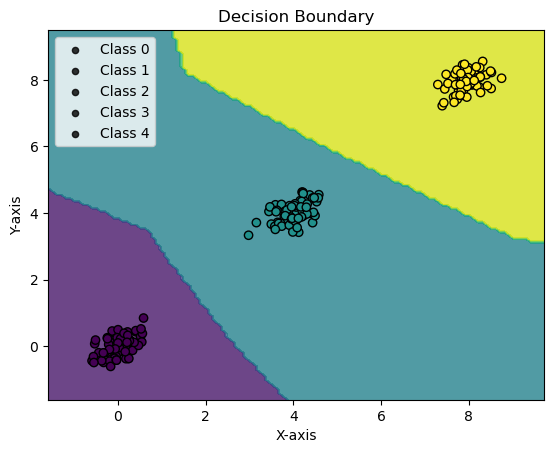

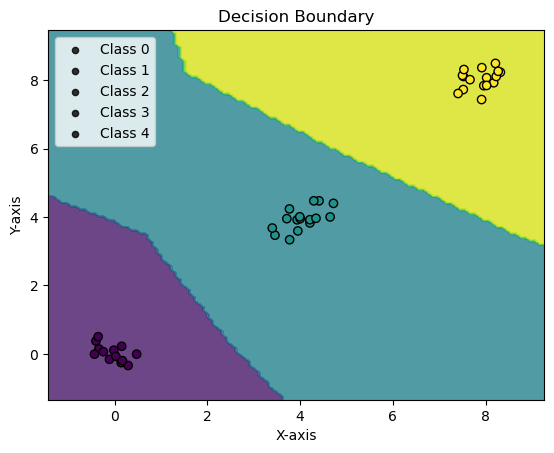

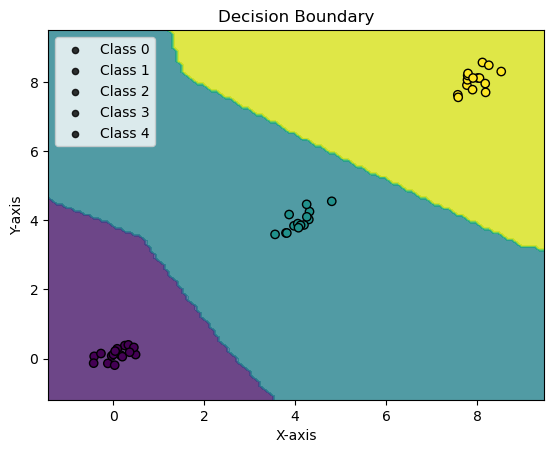

In [185]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def plot_decision_boundary(model, X, y, n_classes):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                         np.arange(y_min, y_max, 0.1))

    with torch.no_grad():
        model.eval()
        Z = model(torch.FloatTensor(np.c_[xx.ravel(), yy.ravel()])).numpy()
        Z = np.argmax(Z, axis=1)

    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', marker='o', linewidth=1)
    plt.title("Decision Boundary")
    plt.xlabel("X-axis")
    plt.ylabel("Y-axis")

    for i in range(n_classes):
        plt.scatter([], [], c='k', alpha=0.8, s=20, label=f"Class {i}")
    plt.legend(loc='upper left')

    plt.show()

# After training
plot_decision_boundary(model, X_primary_train, y_primary_train, n_classes)
plot_decision_boundary(model, X_primary_val, y_primary_val, n_classes)
plot_decision_boundary(model, X_primary_test, y_primary_test, n_classes)


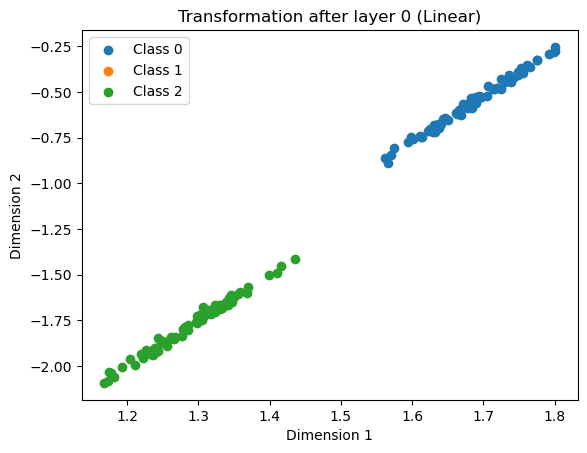

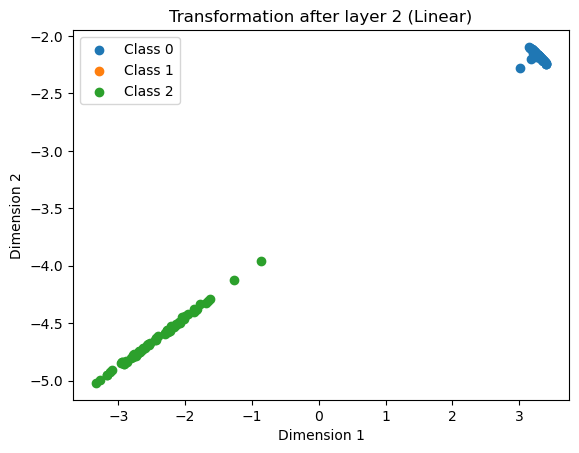

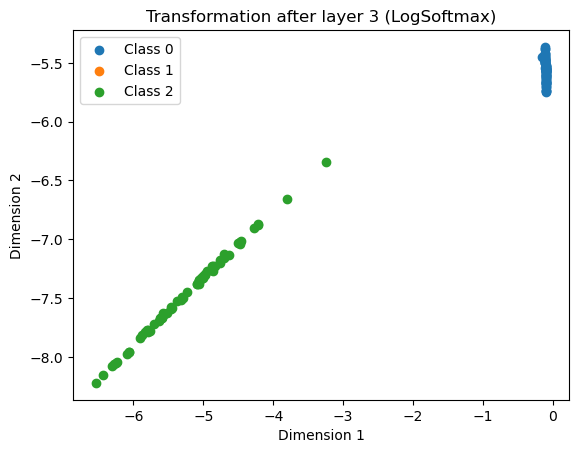

In [186]:
import matplotlib.pyplot as plt

def plot_layer_transformations(model, X, y, layer_indices):
    n_classes = len(np.unique(y))
    X_transformed = torch.FloatTensor(X)
    
    for i, layer_index in enumerate(layer_indices):
        layer = model[layer_index]
        
        with torch.no_grad():
            X_transformed = layer(X_transformed)
            
        if isinstance(layer, nn.Linear) or isinstance(layer, nn.Tanh) or isinstance(layer, nn.LogSoftmax):
            X_transformed_numpy = X_transformed.detach().cpu().numpy()
            
            plt.figure()
            for class_idx in range(n_classes):
                idxs = np.where(y == class_idx)[0]
                plt.scatter(X_transformed_numpy[idxs, 0], X_transformed_numpy[idxs, 1], label=f"Class {class_idx}")
            
            layer_type = type(layer).__name__
            plt.title(f'Transformation after layer {layer_index} ({layer_type})')
            plt.xlabel('Dimension 1')
            plt.ylabel('Dimension 2')
            plt.legend()

# Indicate which layers you are interested in (by index).
layer_indices = list(range(depth*2))

# X should be your original data and y should be the labels.
plot_layer_transformations(model, X_primary_train, y_primary_train, layer_indices)

plt.show()


In [187]:
eval(model, device, test_loader, debug=True, classification_report_flag = True)


Train set: Average loss: 0.1739, Accuracy: 46.0/46 (100%)

              precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00        16
     Class 1       1.00      1.00      1.00        14
     Class 2       1.00      1.00      1.00        16

    accuracy                           1.00        46
   macro avg       1.00      1.00      1.00        46
weighted avg       1.00      1.00      1.00        46



1.0

In [188]:
#save model
# torch.save(model, f"model_{depth}_synthetic_data_against_overfitting.pt")

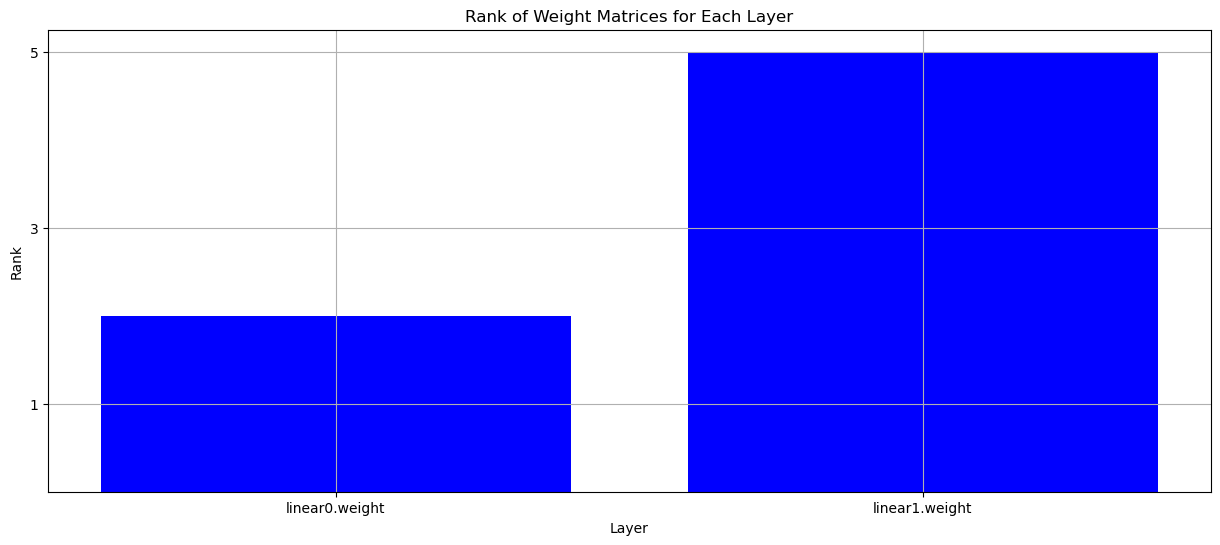

In [189]:
import numpy as np
import matplotlib.pyplot as plt

def plot_layer_ranks(model):
    ranks = []
    layer_names = []
    
    for name, param in model.named_parameters():
        if 'weight' in name:  # We are only interested in weight matrices
            weight_matrix = param.detach().cpu().numpy()
            rank = np.linalg.matrix_rank(weight_matrix)
            ranks.append(rank)
            layer_names.append(name)
    
    # Plotting
    plt.figure(figsize=(15, 6))
    plt.bar(layer_names, ranks, color='blue')
    plt.xlabel('Layer')
    plt.ylabel('Rank')
    plt.title('Rank of Weight Matrices for Each Layer')
    plt.grid(True)
    
    y_max = np.max(ranks) + 1  # Get maximum rank and add 1 for better visualization
    y_min = np.min(ranks) - 1  # Get minimum rank and subtract 1 for better visualization
    plt.yticks(np.arange(y_min, y_max, step=2))  # Set yticks

    plt.show()

# Example usage
plot_layer_ranks(model)  # Note: You'll need to define or load 'model' before calling this function


linear0.weight: 1.9658
linear1.weight: 3.1679


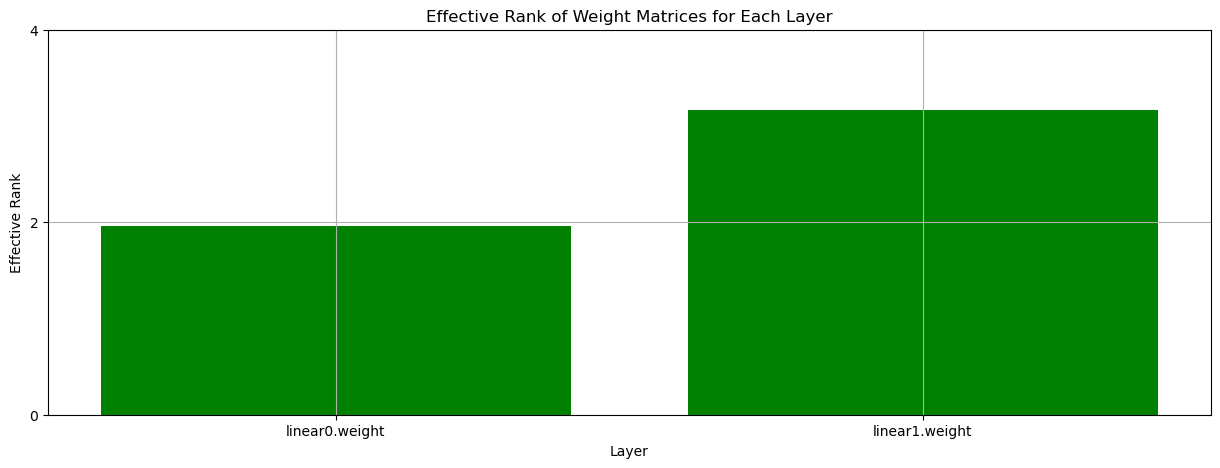

In [190]:
import numpy as np
import matplotlib.pyplot as plt
import torch

'''def effective_rank(singular_values):
    sigma_max = np.max(singular_values)
    sigma_min = singular_values[-1] if singular_values[-1] > 0 else np.min(singular_values[singular_values > 0])
    # print(sigma_max, sigma_min)
    print(np.sqrt(sigma_max / sigma_min))
    print('----')
    return np.sqrt(sigma_max / sigma_min)'''

def effective_rank(singular_values):
    normalized_singular_values = singular_values / np.sum(singular_values)
    entropy = -np.sum(normalized_singular_values * np.log(normalized_singular_values))
    eff_rank = np.exp(entropy)
    return eff_rank

def plot_layer_effective_ranks(model, print_ranks=True):
    effective_ranks = []
    layer_names = []
    
    for name, param in model.named_parameters():
        if 'weight' in name:  # We are only interested in weight matrices
            weight_matrix = param.detach().cpu().numpy()
            singular_values = np.linalg.svd(weight_matrix, compute_uv=False)
            eff_rank = effective_rank(singular_values)
            effective_ranks.append(eff_rank)
            layer_names.append(name)

    if print_ranks:
        for layer_name, eff_rank in zip(layer_names, effective_ranks):
            print(f'{layer_name}: {eff_rank:.4f}')
    
    # Plotting
    plt.figure(figsize=(15, 5))
    plt.bar(layer_names, effective_ranks, color='green')
    plt.xlabel('Layer')
    plt.ylabel('Effective Rank')
    plt.title('Effective Rank of Weight Matrices for Each Layer')
    plt.grid(True)
    
    y_max = np.max(effective_ranks) + 1  # Get maximum rank and add 1 for better visualization
    y_min = np.min(effective_ranks) - 1  # Get minimum rank and subtract 1 for better visualization
    plt.yticks(np.arange(0, int(y_max)+2, step=2))  # Set yticks

    plt.show()

# Example usage
plot_layer_effective_ranks(model)  # Note: You'll need to define or load 'model' before calling this function


/Users/davidguzman/Documents/GitHub/mp-tl-study/David/../plots.py:103: UserWarning:

FixedFormatter should only be used together with FixedLocator

/Users/davidguzman/Documents/GitHub/mp-tl-study/David/../plots.py:114: UserWarning:

FixedFormatter should only be used together with FixedLocator



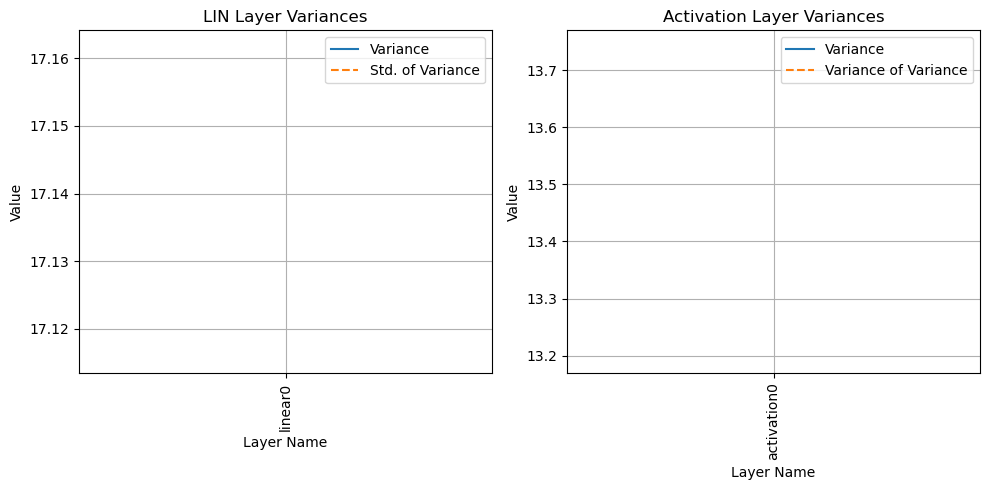

In [191]:
results, variances = compute_layer_variances_dense(model, test_loader, device = 'cpu',cnn=False)
plot_variances_by_layer_type(variances, results, cnn = False, ignore_final_layer=True, std_of_variance = True )

----

# Finetuning experiments

## Baseline model: end2end with the same architecture as the preatining model

In [192]:
#relabeling 

mapping = {1: 0, 3: 1}

y_transfer_train_v1 = np.array([mapping[label] for label in y_transfer_train])
y_transfer_val_v1 = np.array([mapping[label] for label in y_transfer_val])
y_transfer_test_v1 = np.array([mapping[label] for label in y_transfer_test])

In [193]:
# Convert transfer training data to PyTorch tensors
X_transfer_train_tensor = torch.FloatTensor(X_transfer_train)
y_transfer_train_tensor = torch.LongTensor(y_transfer_train_v1)

# Convert trasnfer validation data to PyTorch tensors
X_transfer_val_tensor = torch.FloatTensor(X_transfer_val)
y_transfer_val_tensor = torch.LongTensor(y_transfer_val_v1)

# Convert trasnfer test data to PyTorch tensors
X_transfer_test_tensor = torch.FloatTensor(X_transfer_test)
y_transfer_test_tensor = torch.LongTensor(y_transfer_test_v1)

# Create DataLoaders for transfer datasets
train_dataset_transfer = TensorDataset(X_transfer_train_tensor, y_transfer_train_tensor)
val_dataset_transfer = TensorDataset(X_transfer_val_tensor, y_transfer_val_tensor)
test_dataset_transfer = TensorDataset(X_transfer_test_tensor, y_transfer_test_tensor)

train_loader_transfer = DataLoader(train_dataset_transfer, batch_size=32, shuffle=True)
val_loader_transfer = DataLoader(val_dataset_transfer, batch_size=32, shuffle=False)
test_loader_transfer = DataLoader(test_dataset_transfer, batch_size=32, shuffle=False)

In [194]:
# 2. Create a new model and copy weights from the original model, then adjust the final layer
new_n_classes = 2  # Number of classes in the new dataset
model_finetuning_baseline = generate_fc_dnn(input_dim, new_n_classes, params)

# 3. Fine-tune on the new data

dataset_namespace_new = SimpleNamespace(train_loader=train_loader_transfer, test_loader=test_loader_transfer, val_loader=test_loader_transfer)

# Train and evaluate the new model on the new data
train_acc_new, test_acc_new, model_finetuning_baseline, _ = compute_training_acc_epochs(model_finetuning_baseline, dataset_namespace_new, params, debug=True)

print(f"Final Training Accuracy (New Data): {train_acc_new:.4f}")
print(f"Final Test Accuracy (New Data): {test_acc_new:.4f}")

Epoch: 0 	Training Accuracy: 52.52%
Validation Accuracy: 51.61%
Epoch: 1 	Training Accuracy: 53.24%
Validation Accuracy: 51.61%
val_acc: 0.5161290322580645, max_val_acc: 0.5161290322580645, no_improve_epochs: 1
Epoch: 2 	Training Accuracy: 43.88%
Validation Accuracy: 51.61%
val_acc: 0.5161290322580645, max_val_acc: 0.5161290322580645, no_improve_epochs: 2
Epoch: 3 	Training Accuracy: 55.40%
Validation Accuracy: 54.84%
Epoch: 4 	Training Accuracy: 63.31%
Validation Accuracy: 61.29%
Epoch: 5 	Training Accuracy: 75.54%
Validation Accuracy: 64.52%
Epoch: 6 	Training Accuracy: 92.81%
Validation Accuracy: 90.32%


Epoch: 7 	Training Accuracy: 98.56%
Validation Accuracy: 100.00%
Epoch: 8 	Training Accuracy: 99.28%
Validation Accuracy: 100.00%
val_acc: 1.0, max_val_acc: 1.0, no_improve_epochs: 1
Epoch: 9 	Training Accuracy: 100.00%
Validation Accuracy: 100.00%
val_acc: 1.0, max_val_acc: 1.0, no_improve_epochs: 2
Epoch: 10 	Training Accuracy: 100.00%
Validation Accuracy: 100.00%
val_acc: 1.0, max_val_acc: 1.0, no_improve_epochs: 3
Epoch: 11 	Training Accuracy: 100.00%
Validation Accuracy: 100.00%
val_acc: 1.0, max_val_acc: 1.0, no_improve_epochs: 4
Epoch: 12 	Training Accuracy: 100.00%
Validation Accuracy: 100.00%
val_acc: 1.0, max_val_acc: 1.0, no_improve_epochs: 5
Epoch: 13 	Training Accuracy: 100.00%
Validation Accuracy: 100.00%
val_acc: 1.0, max_val_acc: 1.0, no_improve_epochs: 6
Epoch: 14 	Training Accuracy: 100.00%
Validation Accuracy: 100.00%
val_acc: 1.0, max_val_acc: 1.0, no_improve_epochs: 7
Epoch: 15 	Training Accuracy: 100.00%
Validation Accuracy: 100.00%
val_acc: 1.0, max_val_acc: 1.0,

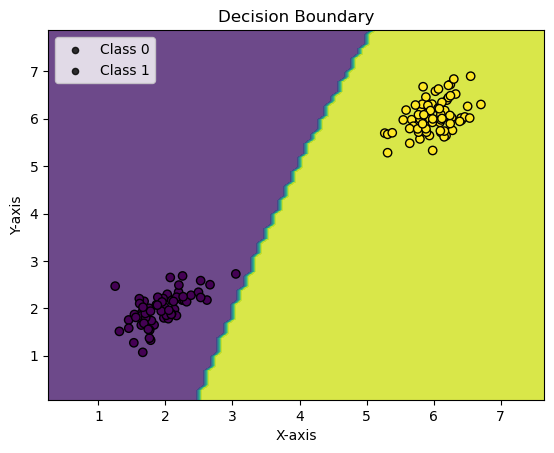

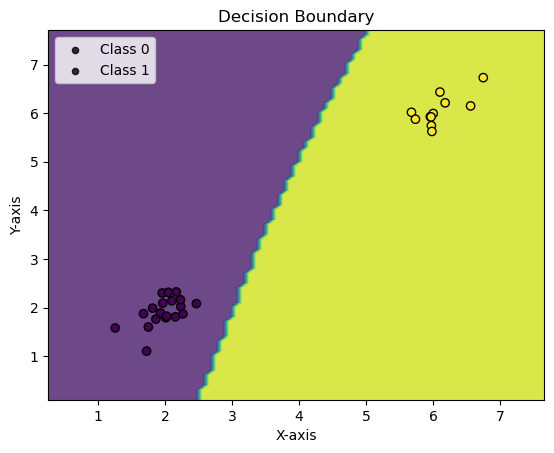

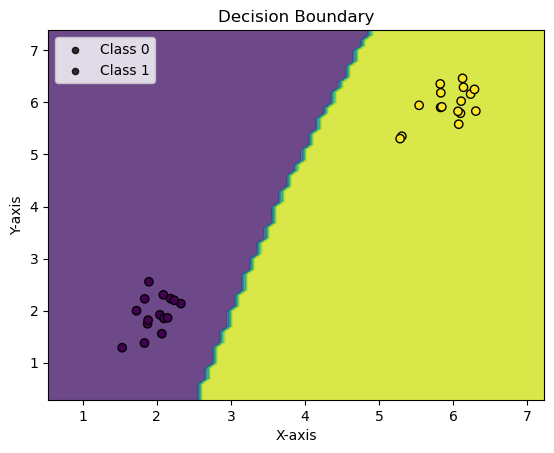

In [195]:
plot_decision_boundary(model_finetuning_baseline, X_transfer_train, y_transfer_train, n_classes=2)
plot_decision_boundary(model_finetuning_baseline, X_transfer_val, y_transfer_val, n_classes=2)
plot_decision_boundary(model_finetuning_baseline, X_transfer_test, y_transfer_test, n_classes=2)


Train set: Average loss: 0.1182, Accuracy: 31.0/31 (100%)

              precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00        15
     Class 1       1.00      1.00      1.00        16

    accuracy                           1.00        31
   macro avg       1.00      1.00      1.00        31
weighted avg       1.00      1.00      1.00        31

linear0.weight: 1.9064
linear1.weight: 1.8796


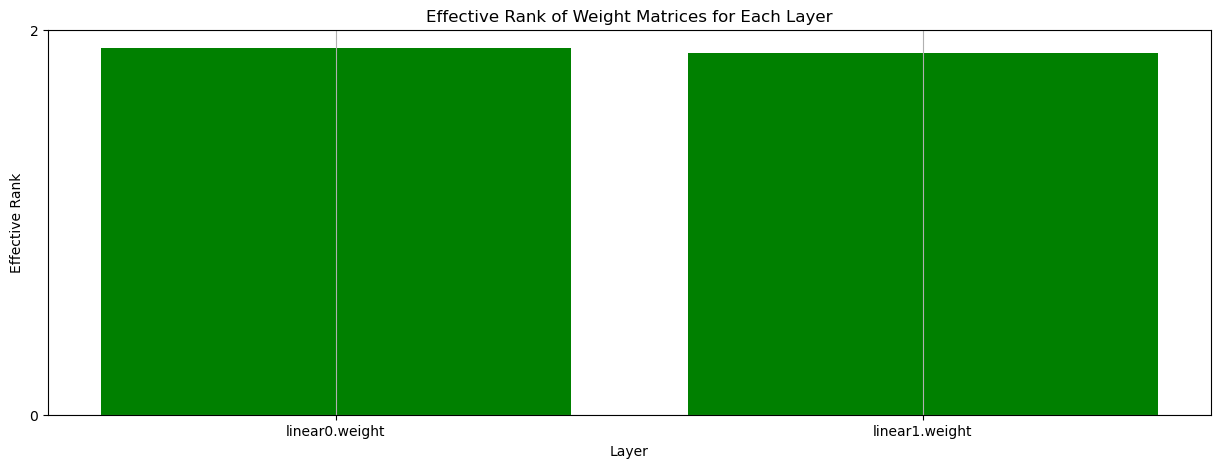

/Users/davidguzman/Documents/GitHub/mp-tl-study/David/../plots.py:103: UserWarning:

FixedFormatter should only be used together with FixedLocator

/Users/davidguzman/Documents/GitHub/mp-tl-study/David/../plots.py:114: UserWarning:

FixedFormatter should only be used together with FixedLocator



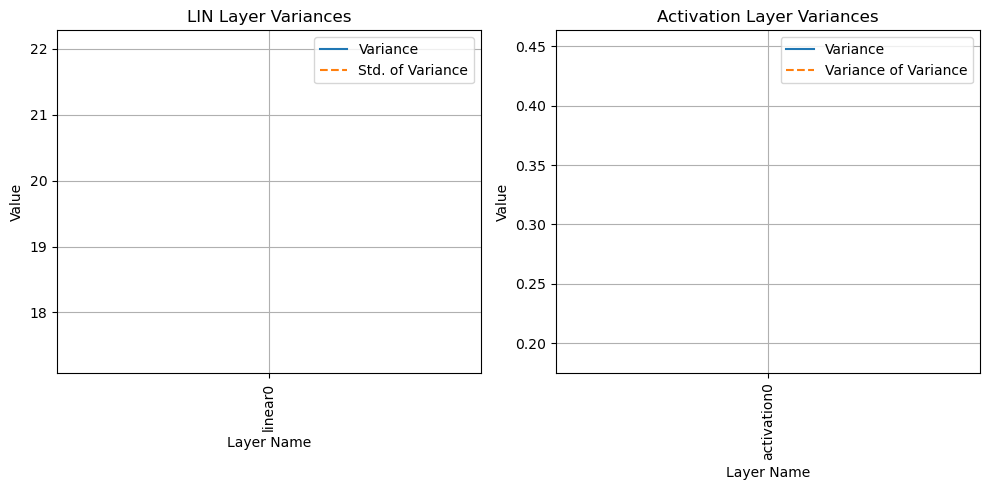

In [196]:
eval(model_finetuning_baseline, device, test_loader_transfer, debug=True, classification_report_flag = True)
plot_layer_effective_ranks(model_finetuning_baseline)
results, variances = compute_layer_variances_dense(model_finetuning_baseline, test_loader_transfer, device = 'cpu',cnn=False)
plot_variances_by_layer_type(variances, results, cnn = False, ignore_final_layer=True, std_of_variance = True )

## Only heads and data for new classes

In [197]:
import torch.utils.data as data

def reduce_dataset(dataloader, percentage, seed=42):
    """
    Reduces the dataset to the given percentage.

    Parameters:
    - dataloader: PyTorch DataLoader object.
    - percentage: Desired percentage of the original dataset.
    - seed: Seed for reproducibility.

    Returns:
    - reduced_dataloader: DataLoader with the reduced dataset.
    """
    # Extract the dataset from the dataloader
    dataset = dataloader.dataset
    
    # Extract all data and labels from the dataset
    X = [dataset[i][0] for i in range(len(dataset))]
    y = [dataset[i][1] for i in range(len(dataset))]

    # Set the seed for reproducibility
    torch.manual_seed(seed)

    # Determine the number of samples to keep
    num_samples = int(len(dataset) * percentage)
    
    # Randomly select indices without replacement
    indices = torch.randperm(len(dataset))[:num_samples]

    # Use a Subset of the original dataset to create a reduced dataset
    reduced_dataset = data.Subset(dataset, indices)

    # Create a DataLoader with the reduced dataset. 
    # You may want to copy other settings from the original DataLoader (like batch_size).
    reduced_dataloader = data.DataLoader(reduced_dataset, batch_size=dataloader.batch_size, shuffle=True)

    return reduced_dataloader


Epoch: 0 	Training Accuracy: 76.92%
Validation Accuracy: 66.67%
Epoch: 1 	Training Accuracy: 76.92%
Validation Accuracy: 66.67%
val_acc: 0.6666666666666666, max_val_acc: 0.6666666666666666, no_improve_epochs: 1
Epoch: 2 	Training Accuracy: 76.92%
Validation Accuracy: 66.67%
val_acc: 0.6666666666666666, max_val_acc: 0.6666666666666666, no_improve_epochs: 2
Epoch: 3 	Training Accuracy: 76.92%
Validation Accuracy: 66.67%
val_acc: 0.6666666666666666, max_val_acc: 0.6666666666666666, no_improve_epochs: 3
Epoch: 4 	Training Accuracy: 76.92%
Validation Accuracy: 66.67%
val_acc: 0.6666666666666666, max_val_acc: 0.6666666666666666, no_improve_epochs: 4
Epoch: 5 	Training Accuracy: 76.92%
Validation Accuracy: 66.67%
val_acc: 0.6666666666666666, max_val_acc: 0.6666666666666666, no_improve_epochs: 5
Epoch: 6 	Training Accuracy: 76.92%
Validation Accuracy: 66.67%
val_acc: 0.6666666666666666, max_val_acc: 0.6666666666666666, no_improve_epochs: 6
Epoch: 7 	Training Accuracy: 76.92%
Validation Accurac

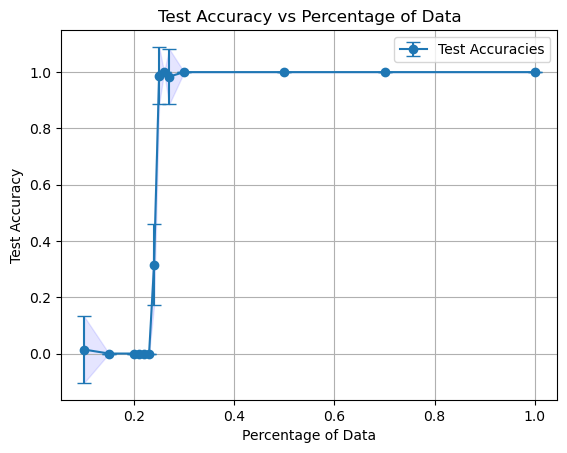

In [202]:
import numpy as np
import matplotlib.pyplot as plt

#percentages = np.linspace(0.1, 1.0, 10)  # from 10% to 100%
percentages = [0.1, 0.15, 0.2, 0.21, 0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.3, 0.5, 0.7, 1]
repeats = 70

# Store results for each percentage
results = {}
best_models = {}

for perc in percentages:
    test_accuracies = []
    best_accuracy = 0.0
    for _ in range(repeats):
        model_new = generate_fc_dnn(input_dim, new_n_classes, params)
        
        # Copy weights
        for name, param in model.named_parameters():
            if "linear" + str(depth-1) not in name:
                model_new._parameters[name] = param
        
        # Reduce datasets
        train_loader_transfer_reduced = reduce_dataset(train_loader_transfer, perc)
        test_loader_transfer_reduced = reduce_dataset(test_loader_transfer, perc)
        val_loader_transfer_reduced = reduce_dataset(val_loader_transfer, perc)
        
        dataset_namespace_new = SimpleNamespace(train_loader=train_loader_transfer_reduced, test_loader=test_loader_transfer_reduced, val_loader=val_loader_transfer_reduced)
        
        _, test_acc_new, _, _ = compute_training_acc_epochs(model_new, dataset_namespace_new, params, debug=True)
        test_accuracies.append(test_acc_new)

        # Check if this model is the best-performing for this percentage
        if test_acc_new > best_accuracy:
            best_accuracy = test_acc_new
            best_models[perc] = model_new.state_dict()  # Save only the model's parameters (state_dict)
    
    results[perc] = test_accuracies

# Save the best models
# for perc in best_models:
#     torch.save(best_models[perc], f"best_model_{int(perc*100)}_percent.pth")

# Plot the results
means = [np.mean(results[perc]) for perc in percentages]
stds = [np.std(results[perc]) for perc in percentages]
plt.errorbar(percentages, means, yerr=stds, fmt='-o', capsize=5, label="Test Accuracies")
plt.fill_between(percentages, np.subtract(means, stds), np.add(means, stds), color='b', alpha=0.1)

plt.xlabel("Percentage of Data")
plt.ylabel("Test Accuracy")
plt.title("Test Accuracy vs Percentage of Data")
plt.legend()
plt.grid(True)
plt.show()


Percentage: 0.10

Train set: Average loss: 0.8912, Accuracy: 15.0/31 (48%)

              precision    recall  f1-score   support

     Class 0       0.48      1.00      0.65        15
     Class 1       0.00      0.00      0.00        16

    accuracy                           0.48        31
   macro avg       0.24      0.50      0.33        31
weighted avg       0.23      0.48      0.32        31



/Users/davidguzman/miniforge3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/davidguzman/miniforge3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/davidguzman/miniforge3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



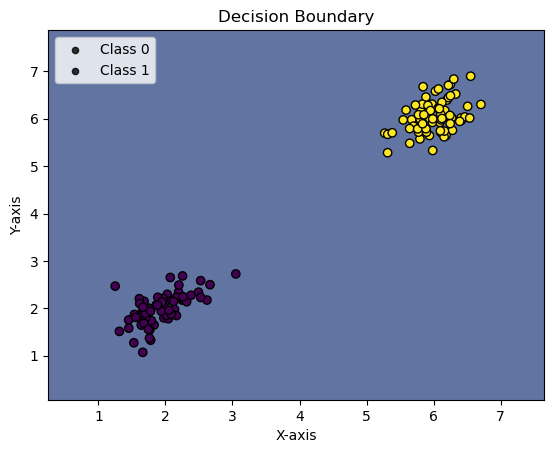

Percentage: 0.24

Train set: Average loss: 0.4110, Accuracy: 31.0/31 (100%)

              precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00        15
     Class 1       1.00      1.00      1.00        16

    accuracy                           1.00        31
   macro avg       1.00      1.00      1.00        31
weighted avg       1.00      1.00      1.00        31



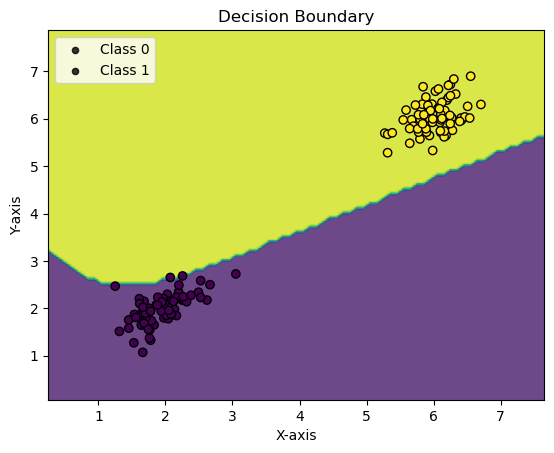

Percentage: 0.25

Train set: Average loss: 0.4854, Accuracy: 31.0/31 (100%)

              precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00        15
     Class 1       1.00      1.00      1.00        16

    accuracy                           1.00        31
   macro avg       1.00      1.00      1.00        31
weighted avg       1.00      1.00      1.00        31



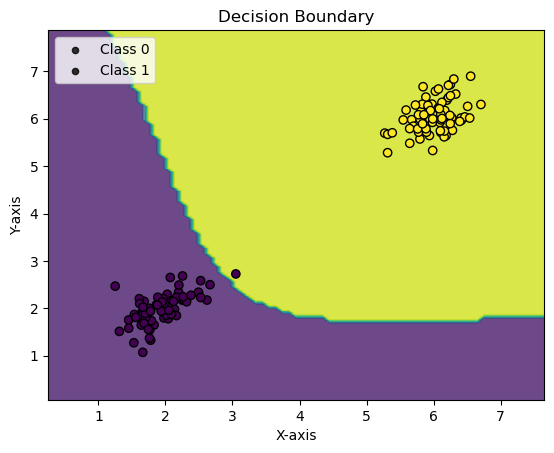

Percentage: 0.26

Train set: Average loss: 0.5734, Accuracy: 31.0/31 (100%)

              precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00        15
     Class 1       1.00      1.00      1.00        16

    accuracy                           1.00        31
   macro avg       1.00      1.00      1.00        31
weighted avg       1.00      1.00      1.00        31



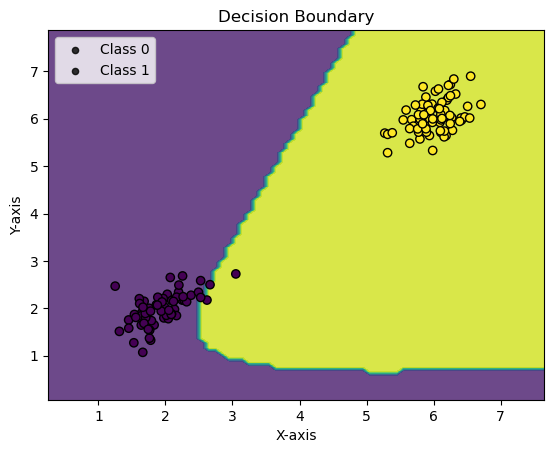

Percentage: 0.27

Train set: Average loss: 0.3341, Accuracy: 31.0/31 (100%)

              precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00        15
     Class 1       1.00      1.00      1.00        16

    accuracy                           1.00        31
   macro avg       1.00      1.00      1.00        31
weighted avg       1.00      1.00      1.00        31



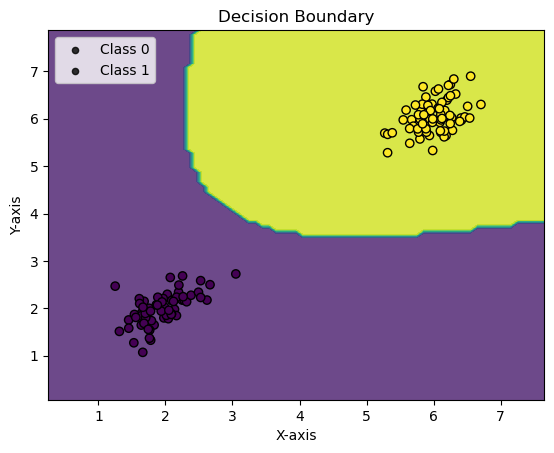

Percentage: 0.30

Train set: Average loss: 0.3575, Accuracy: 31.0/31 (100%)

              precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00        15
     Class 1       1.00      1.00      1.00        16

    accuracy                           1.00        31
   macro avg       1.00      1.00      1.00        31
weighted avg       1.00      1.00      1.00        31



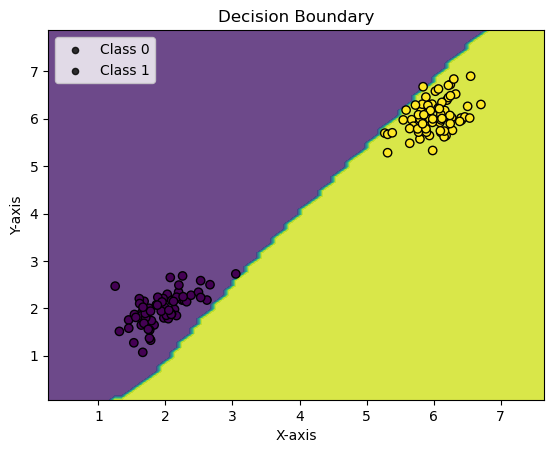

Percentage: 0.50

Train set: Average loss: 0.5072, Accuracy: 31.0/31 (100%)

              precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00        15
     Class 1       1.00      1.00      1.00        16

    accuracy                           1.00        31
   macro avg       1.00      1.00      1.00        31
weighted avg       1.00      1.00      1.00        31



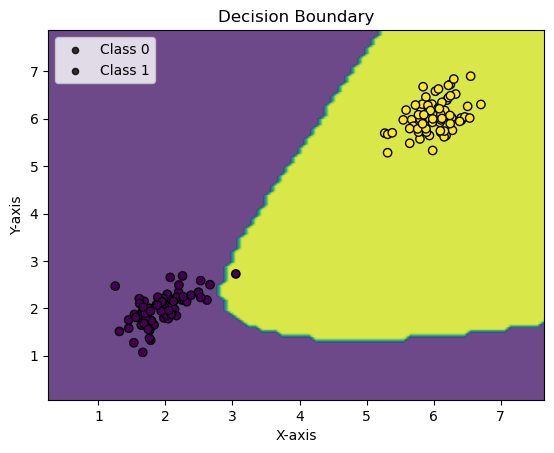

Percentage: 0.70

Train set: Average loss: 0.3448, Accuracy: 31.0/31 (100%)

              precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00        15
     Class 1       1.00      1.00      1.00        16

    accuracy                           1.00        31
   macro avg       1.00      1.00      1.00        31
weighted avg       1.00      1.00      1.00        31



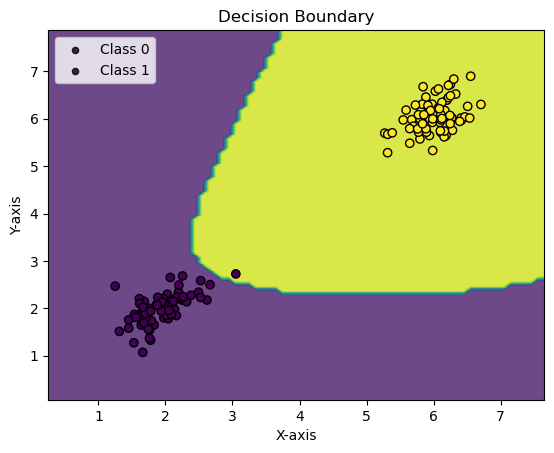

Percentage: 1.00

Train set: Average loss: 0.3075, Accuracy: 31.0/31 (100%)

              precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00        15
     Class 1       1.00      1.00      1.00        16

    accuracy                           1.00        31
   macro avg       1.00      1.00      1.00        31
weighted avg       1.00      1.00      1.00        31



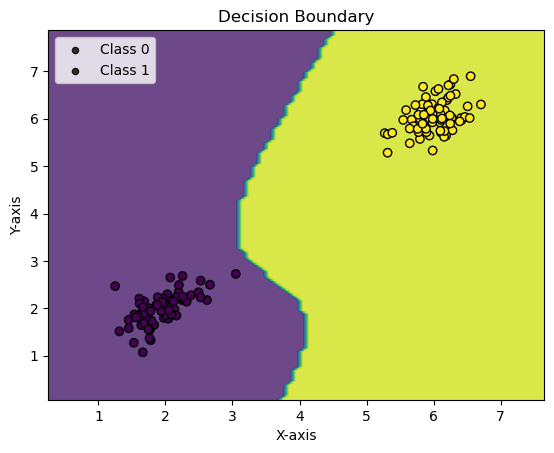

In [206]:
# iterate over keys and values of best_models
for perc, model_state_dict in best_models.items():
    print(f"Percentage: {perc:.2f}")
    model_temp = generate_fc_dnn(input_dim, new_n_classes, params)
    model_temp.load_state_dict(model_state_dict)
    eval(model_temp, device, test_loader_transfer, debug=True, classification_report_flag = True)
    plot_decision_boundary(model_temp, X_transfer_train, y_transfer_train, n_classes=2)
    

In [216]:
# 2. Create a new model and copy weights from the original model, then adjust the final layer
new_n_classes = 2  # Number of classes in the new dataset
model_new = generate_fc_dnn(input_dim, new_n_classes, params)

# Manually copy weights from the original model to the new model for all layers except the final one
for name, param in model.named_parameters():
    if "linear" + str(depth-1) not in name:  # This is to exclude the final layer
        model_new._parameters[name] = param

# 3. Fine-tune on the new data

# Assuming transfer_loader is your DataLoader for the transfer dataset
percentage = 0.2
train_loader_transfer_reduced = reduce_dataset(train_loader_transfer, percentage)
test_loader_transfer_reduced = reduce_dataset(test_loader_transfer, percentage)
val_loader_transfer_reduced = reduce_dataset(val_loader_transfer, percentage)

dataset_namespace_new = SimpleNamespace(train_loader=train_loader_transfer_reduced, test_loader=test_loader_transfer_reduced, val_loader=test_loader_transfer_reduced)

# Train and evaluate the new model on the new data
train_acc_new, test_acc_new, model_new, _ = compute_training_acc_epochs(model_new, dataset_namespace_new, params, debug=True)

print(f"Final Training Accuracy (New Data): {train_acc_new:.4f}")
print(f"Final Test Accuracy (New Data): {test_acc_new:.4f}")

Epoch: 0 	Training Accuracy: 55.56%
Validation Accuracy: 16.67%
Epoch: 1 	Training Accuracy: 62.96%
Validation Accuracy: 16.67%
val_acc: 0.16666666666666666, max_val_acc: 0.16666666666666666, no_improve_epochs: 1
Epoch: 2 	Training Accuracy: 77.78%
Validation Accuracy: 33.33%
Epoch: 3 	Training Accuracy: 92.59%
Validation Accuracy: 50.00%
Epoch: 4 	Training Accuracy: 92.59%
Validation Accuracy: 83.33%
Epoch: 5 	Training Accuracy: 96.30%
Validation Accuracy: 100.00%
Epoch: 6 	Training Accuracy: 96.30%
Validation Accuracy: 100.00%
val_acc: 1.0, max_val_acc: 1.0, no_improve_epochs: 1
Epoch: 7 	Training Accuracy: 96.30%
Validation Accuracy: 100.00%
val_acc: 1.0, max_val_acc: 1.0, no_improve_epochs: 2
Epoch: 8 	Training Accuracy: 96.30%
Validation Accuracy: 100.00%
val_acc: 1.0, max_val_acc: 1.0, no_improve_epochs: 3
Epoch: 9 	Training Accuracy: 96.30%
Validation Accuracy: 100.00%
val_acc: 1.0, max_val_acc: 1.0, no_improve_epochs: 4
Epoch: 10 	Training Accuracy: 96.30%
Validation Accuracy: 

In [217]:
print(model_new)

Sequential(
  (linear0): Linear(in_features=2, out_features=5, bias=True)
  (activation0): Tanh()
  (linear1): Linear(in_features=5, out_features=2, bias=True)
  (activation1): LogSoftmax(dim=1)
)



Train set: Average loss: 0.3871, Accuracy: 31.0/31 (100%)

              precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00        15
     Class 1       1.00      1.00      1.00        16

    accuracy                           1.00        31
   macro avg       1.00      1.00      1.00        31
weighted avg       1.00      1.00      1.00        31



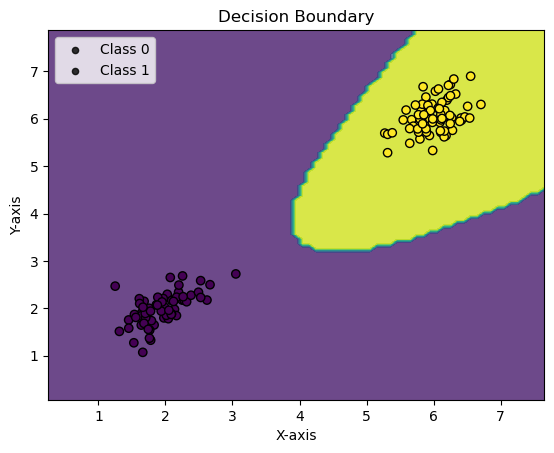

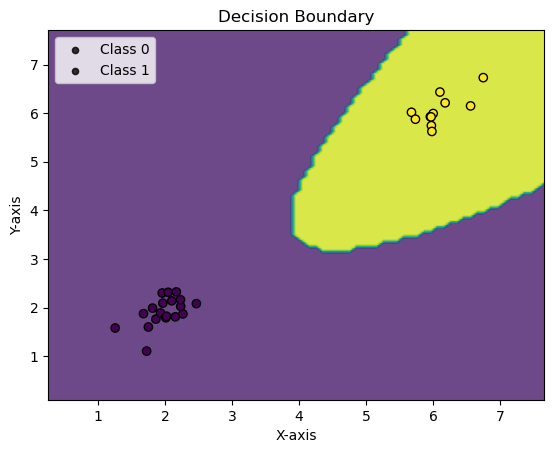

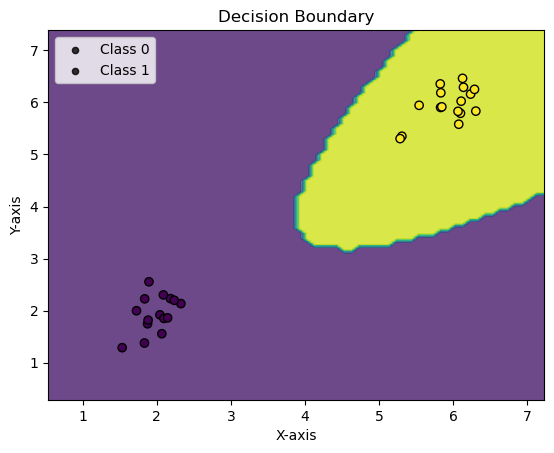

In [218]:
eval(model_new, device, test_loader_transfer, debug=True, classification_report_flag = True)
plot_decision_boundary(model_new, X_transfer_train, y_transfer_train, n_classes=2)
plot_decision_boundary(model_new, X_transfer_val, y_transfer_val, n_classes=2)
plot_decision_boundary(model_new, X_transfer_test, y_transfer_test, n_classes=2)

## Heads for all classes and data for new classes (so we test on all classes)

In [93]:
# Convert transfer training data to PyTorch tensors
X_transfer_train_tensor = torch.FloatTensor(X_transfer_train)
y_transfer_train_tensor = torch.LongTensor(y_transfer_train)

# Convert trasnfer validation data to PyTorch tensors
X_transfer_val_tensor = torch.FloatTensor(X_transfer_val)
y_transfer_val_tensor = torch.LongTensor(y_transfer_val)

# Convert trasnfer test data to PyTorch tensors
X_transfer_test_tensor = torch.FloatTensor(X_transfer_test)
y_transfer_test_tensor = torch.LongTensor(y_transfer_test)

# Create DataLoaders for transfer datasets
train_dataset_transfer = TensorDataset(X_transfer_train_tensor, y_transfer_train_tensor)
val_dataset_transfer = TensorDataset(X_transfer_val_tensor, y_transfer_val_tensor)
test_dataset_transfer = TensorDataset(X_transfer_test_tensor, y_transfer_test_tensor)

train_loader_transfer = DataLoader(train_dataset_transfer, batch_size=32, shuffle=True)
val_loader_transfer = DataLoader(val_dataset_transfer, batch_size=32, shuffle=False)
test_loader_transfer = DataLoader(test_dataset_transfer, batch_size=32, shuffle=False)

#update the namesapce

dataset_namespace_new_2 = SimpleNamespace(train_loader=train_loader_transfer, test_loader=test_loader_transfer, val_loader=test_loader_transfer)

In [226]:
# Train and evaluate the new model on the new data

model_new_2 = copy.deepcopy(model)

train_acc_new_2, test_acc_new_2, model_new_2, _ = compute_training_acc_epochs(model_new_2, dataset_namespace_new_2, params, debug=True)

print(f"Final Training Accuracy (New Data): {train_acc_new_2:.4f}")
print(f"Final Test Accuracy (New Data): {test_acc_new_2:.4f}")

Epoch: 0 	Training Accuracy: 0.00%
Validation Accuracy: 0.00%
val_acc: 0.0, max_val_acc: 0.0, no_improve_epochs: 1
Epoch: 1 	Training Accuracy: 0.00%
Validation Accuracy: 0.00%
val_acc: 0.0, max_val_acc: 0.0, no_improve_epochs: 2
Epoch: 2 	Training Accuracy: 0.00%
Validation Accuracy: 0.00%
val_acc: 0.0, max_val_acc: 0.0, no_improve_epochs: 3
Epoch: 3 	Training Accuracy: 0.00%
Validation Accuracy: 0.00%
val_acc: 0.0, max_val_acc: 0.0, no_improve_epochs: 4
Epoch: 4 	Training Accuracy: 0.00%
Validation Accuracy: 0.00%
val_acc: 0.0, max_val_acc: 0.0, no_improve_epochs: 5
Epoch: 5 	Training Accuracy: 0.00%
Validation Accuracy: 0.00%
val_acc: 0.0, max_val_acc: 0.0, no_improve_epochs: 6
Epoch: 6 	Training Accuracy: 0.00%
Validation Accuracy: 0.00%
val_acc: 0.0, max_val_acc: 0.0, no_improve_epochs: 7
Epoch: 7 	Training Accuracy: 5.04%
Validation Accuracy: 9.68%
Epoch: 8 	Training Accuracy: 52.52%
Validation Accuracy: 51.61%
Epoch: 9 	Training Accuracy: 52.52%
Validation Accuracy: 51.61%
val_a

In [228]:
print(model_new_2)

Sequential(
  (linear0): Linear(in_features=2, out_features=5, bias=True)
  (activation0): ReLU()
  (linear1): Linear(in_features=5, out_features=5, bias=True)
  (activation1): LogSoftmax(dim=1)
)


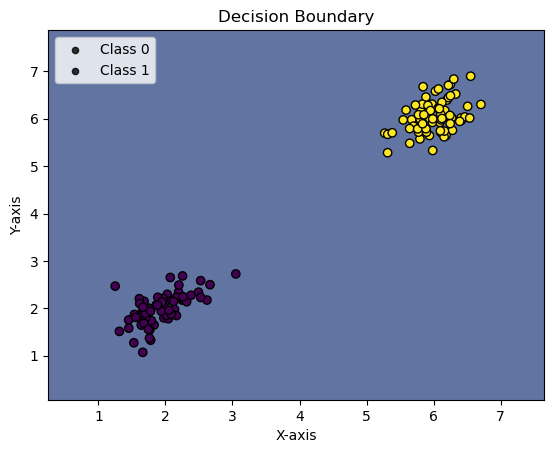

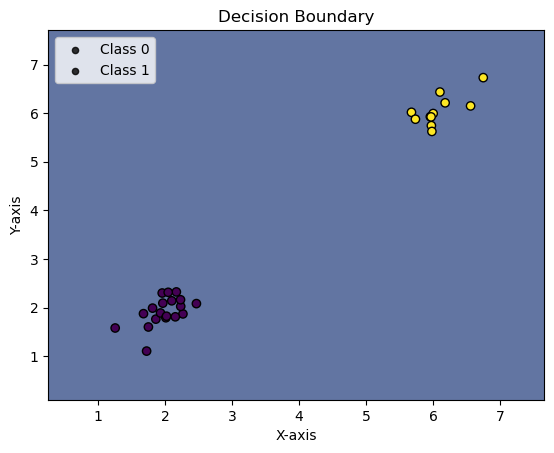

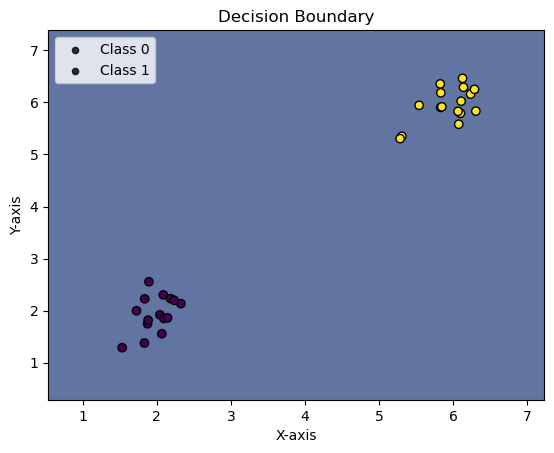

In [227]:
plot_decision_boundary(model_new_2, X_transfer_train, y_transfer_train, n_classes=2)
plot_decision_boundary(model_new_2, X_transfer_val, y_transfer_val, n_classes=2)
plot_decision_boundary(model_new_2, X_transfer_test, y_transfer_test, n_classes=2)

In [229]:
#combine the primary and transfer test data and evaluate on the new model
X_combined_test = np.concatenate((X_primary_test, X_transfer_test))
y_combined_test = np.concatenate((y_primary_test, y_transfer_test))

# Convert combined test data to PyTorch tensors
X_combined_test_tensor = torch.FloatTensor(X_combined_test)
y_combined_test_tensor = torch.LongTensor(y_combined_test)

# Create DataLoader for combined test data
combined_test_dataset = TensorDataset(X_combined_test_tensor, y_combined_test_tensor)
combined_test_loader = DataLoader(combined_test_dataset, batch_size=32, shuffle=False)

# Evaluate the new model on the combined test data
test_acc_combined = eval(model_new_2, device, combined_test_loader, debug=True, classification_report_flag = True)


Train set: Average loss: 5.9829, Accuracy: 22.0/77 (29%)

              precision    recall  f1-score   support

     Class 0       1.00      0.38      0.55        16
     Class 1       0.00      0.00      0.00        15
     Class 2       0.00      0.00      0.00        14
     Class 3       0.23      1.00      0.37        16
     Class 4       0.00      0.00      0.00        16

    accuracy                           0.29        77
   macro avg       0.25      0.28      0.18        77
weighted avg       0.25      0.29      0.19        77



/Users/davidguzman/miniforge3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/davidguzman/miniforge3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/davidguzman/miniforge3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



catastrophic forgetting problem

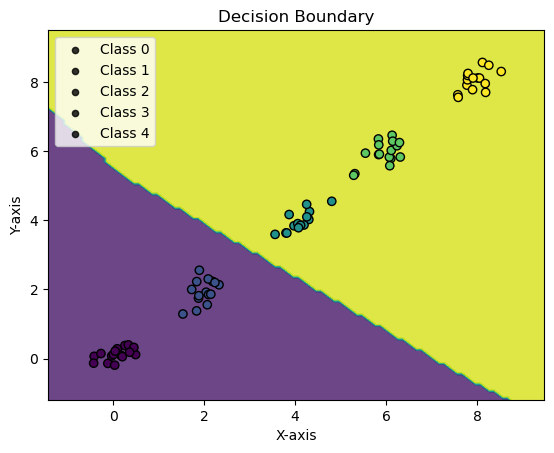

In [98]:
plot_decision_boundary(model_new_2, X_combined_test, y_combined_test, n_classes=5)

## Heads for all classes and data for all classes

In [99]:
#combine the primary and transfer train, val and test data 
X_combined_train = np.concatenate((X_primary_train, X_transfer_train))
y_combined_train = np.concatenate((y_primary_train, y_transfer_train))

X_combined_val = np.concatenate((X_primary_val, X_transfer_val))
y_combined_val = np.concatenate((y_primary_val, y_transfer_val))

X_combined_test = np.concatenate((X_primary_test, X_transfer_test))
y_combined_test = np.concatenate((y_primary_test, y_transfer_test))

# Convert combined train, val, and test data to PyTorch tensors
X_combined_train_tensor = torch.FloatTensor(X_combined_train)
y_combined_train_tensor = torch.LongTensor(y_combined_train)

X_combined_val_tensor = torch.FloatTensor(X_combined_val)
y_combined_val_tensor = torch.LongTensor(y_combined_val)

X_combined_test_tensor = torch.FloatTensor(X_combined_test)
y_combined_test_tensor = torch.LongTensor(y_combined_test)

# Create DataLoaders for combined train, val, and test data
train_dataset_combined = TensorDataset(X_combined_train_tensor, y_combined_train_tensor)
val_dataset_combined = TensorDataset(X_combined_val_tensor, y_combined_val_tensor)
test_dataset_combined = TensorDataset(X_combined_test_tensor, y_combined_test_tensor)

train_loader_combined = DataLoader(train_dataset_combined, batch_size=32, shuffle=True)
val_loader_combined = DataLoader(val_dataset_combined, batch_size=32, shuffle=False)
test_loader_combined = DataLoader(test_dataset_combined, batch_size=32, shuffle=False)

#update the namesapce

dataset_namespace_new_3 = SimpleNamespace(train_loader=train_loader_combined, test_loader=test_loader_combined, val_loader=test_loader_combined)


In [100]:
# Train and evaluate the new model on the combined data

model_new_3 = copy.deepcopy(model)

train_acc_new_3, test_acc_new_3, model_new_3, _ = compute_training_acc_epochs(model_new_3, dataset_namespace_new_3, params, debug=True)

print(f"Final Training Accuracy (New Data): {train_acc_new_3:.4f}")
print(f"Final Test Accuracy (New Data): {test_acc_new_3:.4f}")

Epoch: 0 	Training Accuracy: 60.06%
Validation Accuracy: 59.74%
Epoch: 1 	Training Accuracy: 41.38%
Validation Accuracy: 41.56%
val_acc: 0.4155844155844156, max_val_acc: 0.5974025974025974, no_improve_epochs: 1
Epoch: 2 	Training Accuracy: 56.03%
Validation Accuracy: 55.84%
val_acc: 0.5584415584415584, max_val_acc: 0.5974025974025974, no_improve_epochs: 2
Epoch: 3 	Training Accuracy: 75.86%
Validation Accuracy: 76.62%
Epoch: 4 	Training Accuracy: 58.62%
Validation Accuracy: 61.04%
val_acc: 0.6103896103896104, max_val_acc: 0.7662337662337663, no_improve_epochs: 1
Epoch: 5 	Training Accuracy: 66.95%
Validation Accuracy: 67.53%
val_acc: 0.6753246753246753, max_val_acc: 0.7662337662337663, no_improve_epochs: 2
Epoch: 6 	Training Accuracy: 81.03%
Validation Accuracy: 81.82%
Epoch: 7 	Training Accuracy: 69.54%
Validation Accuracy: 74.03%
val_acc: 0.7402597402597403, max_val_acc: 0.8181818181818182, no_improve_epochs: 1
Epoch: 8 	Training Accuracy: 77.59%
Validation Accuracy: 77.92%
val_acc: 

In [101]:
# Evaluate the new model on the combined test data
test_acc_combined = eval(model_new_3, device, combined_test_loader, debug=True, classification_report_flag = True)


Train set: Average loss: 0.3462, Accuracy: 77.0/77 (100%)

              precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00        16
     Class 1       1.00      1.00      1.00        15
     Class 2       1.00      1.00      1.00        14
     Class 3       1.00      1.00      1.00        16
     Class 4       1.00      1.00      1.00        16

    accuracy                           1.00        77
   macro avg       1.00      1.00      1.00        77
weighted avg       1.00      1.00      1.00        77



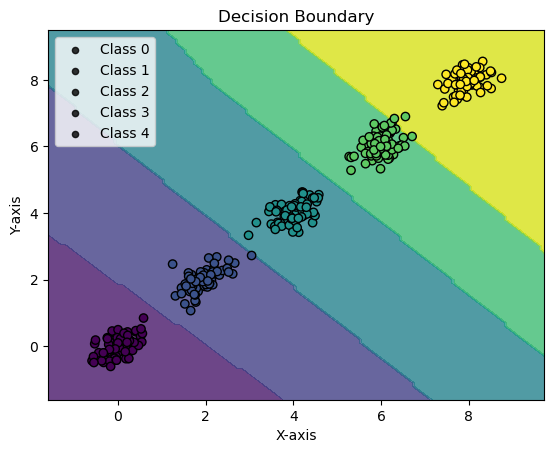

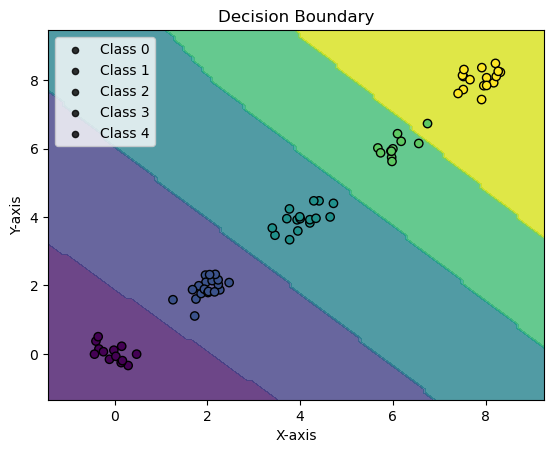

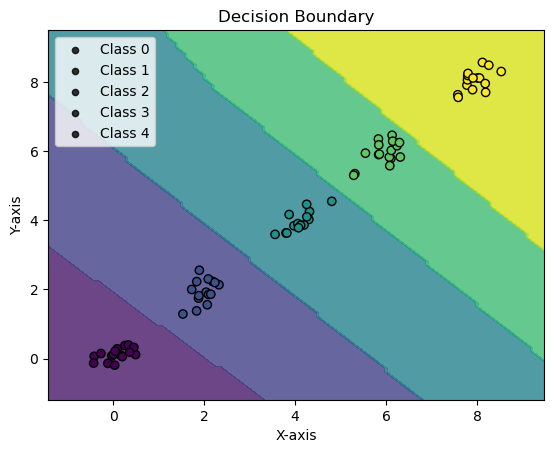

In [102]:
plot_decision_boundary(model_new_3, X_combined_train, y_combined_train, n_classes=5)
plot_decision_boundary(model_new_3, X_combined_val, y_combined_val, n_classes=5)
plot_decision_boundary(model_new_3, X_combined_test, y_combined_test, n_classes=5)
